# Clasificador de reseñas

- **Joan Pedro Bruxola**
- **Julio García Bustos**
- **Marcos Rosique Martínez**
- **Mario Soto Ramos**

Primero importamos todas las librerías importantes

In [1]:
pip install -r requirements.txt

     ---------------------------------------- 0.0/33.5 MB ? eta -:--:--
     - -------------------------------------- 1.0/33.5 MB 6.3 MB/s eta 0:00:06
     -- ------------------------------------- 2.1/33.5 MB 5.3 MB/s eta 0:00:06
     ---- ----------------------------------- 3.9/33.5 MB 6.3 MB/s eta 0:00:05
     ------ --------------------------------- 5.5/33.5 MB 6.7 MB/s eta 0:00:05
     -------- ------------------------------- 6.8/33.5 MB 6.8 MB/s eta 0:00:04
     ---------- ----------------------------- 8.4/33.5 MB 6.9 MB/s eta 0:00:04
     ----------- ---------------------------- 9.4/33.5 MB 6.5 MB/s eta 0:00:04
     ----------- ---------------------------- 9.4/33.5 MB 6.5 MB/s eta 0:00:04
     ----------- ---------------------------- 9.7/33.5 MB 5.6 MB/s eta 0:00:05
     ------------ --------------------------- 10.2/33.5 MB 5.1 MB/s eta 0:00:05
     ------------ --------------------------- 10.7/33.5 MB 4.7 MB/s eta 0:00:05
     ------------- -------------------------- 11.3/33.5 M

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\home\\conda\\feedstock_root\\build_artifacts\\exceptiongroup_1733208806608\\work'



In [58]:
import os
import random
import re
import string
import time
import zipfile
from collections import Counter

import requests
from bs4 import BeautifulSoup
from langdetect import detect, LangDetectException
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

import nltk
from nltk.tokenize import sent_tokenize
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from textblob import TextBlob
from sentence_transformers import SentenceTransformer

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

from transformers import pipeline

## Extracción de URLs

### URLs de las películas

In [ ]:
# paginas a scrapear
paginas_objetivo = [1, 2, 3, 365, 366]
n_por_pagina = 24

url = "https://www.metacritic.com/browse/movie/"

# Evitar bloqueo
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36"
}

# Lista almacenadora
link_list = []

for page in paginas_objetivo:
    print(f"\nAccediendo a página {page}...")

    params = {
        "releaseYearMin": 1990,
        "releaseYearMax": 2014,
        "page": page
    }

    response = requests.get(url, headers=headers, params=params)

    if response.status_code != 200:
        print(f"Error al acceder a la página {page}.")
        continue

    soup = BeautifulSoup(response.content, "html.parser")

    movie_links = soup.find_all("a", class_="c-finderProductCard_container g-color-gray80 u-grid")

    if not movie_links:
        print("No se encontraron películas en esta página.")
        continue

    for idx, link in enumerate(movie_links[:n_por_pagina]):
        href = link.get("href")
        if href:
            full_url = f"https://www.metacritic.com{href}"
            link_list.append(full_url)
            print(f"[Pág. {page}] Película {idx+1}: {full_url}")

    time.sleep(1) 

print(f"\nTotal de enlaces obtenidos: {len(link_list)}")


Accediendo a página 1...
[Pág. 1] Película 1: https://www.metacritic.com/movie/dekalog-1988/
[Pág. 1] Película 2: https://www.metacritic.com/movie/boyhood/
[Pág. 1] Película 3: https://www.metacritic.com/movie/three-colors-red/
[Pág. 1] Película 4: https://www.metacritic.com/movie/the-leopard-re-release/
[Pág. 1] Película 5: https://www.metacritic.com/movie/lawrence-of-arabia-re-release/
[Pág. 1] Película 6: https://www.metacritic.com/movie/fanny-and-alexander-re-release/
[Pág. 1] Película 7: https://www.metacritic.com/movie/army-of-shadows/
[Pág. 1] Película 8: https://www.metacritic.com/movie/pepe-le-moko-re-release/
[Pág. 1] Película 9: https://www.metacritic.com/movie/pans-labyrinth/
[Pág. 1] Película 10: https://www.metacritic.com/movie/hoop-dreams/
[Pág. 1] Película 11: https://www.metacritic.com/movie/metropolis-re-release/
[Pág. 1] Película 12: https://www.metacritic.com/movie/rififi-re-release/
[Pág. 1] Película 13: https://www.metacritic.com/movie/4-months-3-weeks-and-2-days

### URLs de las reseñas

In [ ]:
filters = ['Mixed%20Reviews', 'Negative%20Reviews']

review_links = [f"{link}user-reviews/?filter={filter_type}" for filter_type in filters for link in link_list]
print(f"Tamaño de review_links: {len(review_links)}")

Tamaño de review_links: 240


## Extracción y almacenamiento de reseñas

In [ ]:
def get_user_reviews_selenium(movie_url, max_pages=1, n_res=50):
    chrome_options = Options()
    #chrome_options.add_argument("--headless")  # Ejecutar sin abrir ventana
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("user-agent=Mozilla/5.0")

    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)

    all_reviews = []

    for page in range(max_pages):  
        url = f"{movie_url}&page={page + 1}" 
        driver.get(url)
        time.sleep(2) 

        soup = BeautifulSoup(driver.page_source, "html.parser")

        review_containers = soup.find_all("div", attrs={"data-testid": "product-review"})

        for container in review_containers:
            score_tag = container.find("div", class_="c-siteReviewScore")
            score = score_tag.get_text(strip=True) if score_tag else "No score"

            user_tag = container.find("a", class_="c-siteReviewHeader_username")
            username = user_tag.get_text(strip=True) if user_tag else "No username"

            date_tag = container.find("div", class_="c-siteReviewHeader_reviewDate")
            date = date_tag.get_text(strip=True) if date_tag else "No date"

            quote_tag = container.find("div", class_="c-siteReview_quote")
            review_text = quote_tag.get_text(strip=True) if quote_tag else "No review text"

            all_reviews.append({
                "movie_url": movie_url,  
                "username": username,
                "date": date,
                "score": score,
                "review": review_text
            })

        if len(all_reviews) >= n_res:  
            break

    driver.quit()
    return all_reviews

all_reviews_data = []

# extraer n reseñas para cada enlace
for movie_url in review_links:
    print(f"Extrayendo reseñas de: {movie_url}")
    reviews = get_user_reviews_selenium(movie_url, n_res=50)

    for review in reviews:
        all_reviews_data.append(review)

# Convertir la lista de reseñas a un DataFrame
df_reviews = pd.DataFrame(all_reviews_data)

print(df_reviews.head())

Extrayendo reseñas de: https://www.metacritic.com/movie/dekalog-1988/user-reviews/?filter=Mixed%20Reviews
Extrayendo reseñas de: https://www.metacritic.com/movie/boyhood/user-reviews/?filter=Mixed%20Reviews
Extrayendo reseñas de: https://www.metacritic.com/movie/three-colors-red/user-reviews/?filter=Mixed%20Reviews
Extrayendo reseñas de: https://www.metacritic.com/movie/the-leopard-re-release/user-reviews/?filter=Mixed%20Reviews
Extrayendo reseñas de: https://www.metacritic.com/movie/lawrence-of-arabia-re-release/user-reviews/?filter=Mixed%20Reviews
Extrayendo reseñas de: https://www.metacritic.com/movie/fanny-and-alexander-re-release/user-reviews/?filter=Mixed%20Reviews
Extrayendo reseñas de: https://www.metacritic.com/movie/army-of-shadows/user-reviews/?filter=Mixed%20Reviews
Extrayendo reseñas de: https://www.metacritic.com/movie/pepe-le-moko-re-release/user-reviews/?filter=Mixed%20Reviews
Extrayendo reseñas de: https://www.metacritic.com/movie/pans-labyrinth/user-reviews/?filter=Mi

In [ ]:
df_reviews.to_csv("./data/reviews_finales_bad_mixed_only.csv", index=True)

## Preprocesamiento

In [ ]:
#Cargar datos
df1 = pd.read_csv("./data/reviews_finales.csv")
df2 = pd.read_csv("./data/reviews_finales_2.csv")
df3 = pd.read_csv("./data/reviews_finales_3.csv")
df4 = pd.read_csv("./data/reviews_finales_bad_mixed_only.csv")

df = pd.concat([df1, df2, df3, df4], ignore_index=True)

df = df.drop('Unnamed: 0', axis=1)
print(df.shape)

(9953, 5)


In [4]:
df.head()

,movie_url,username,date,score,review
0,https://www.metacritic.com/movie/moonlight-201...,Randomsquirrel,"Jan 15, 2025",10,It was an absolutely brilliant film. Character...
1,https://www.metacritic.com/movie/moonlight-201...,isabellacosta8,"Oct 10, 2024",10,[SPOILER ALERT: This review contains spoilers.]
2,https://www.metacritic.com/movie/moonlight-201...,Gabrielx593,"Oct 9, 2024",10,[SPOILER ALERT: This review contains spoilers.]
3,https://www.metacritic.com/movie/moonlight-201...,NWR1,"Mar 31, 2024",9,I haven’t felt this much emotion in a long tim...
4,https://www.metacritic.com/movie/moonlight-201...,Alexmarshall,"Oct 16, 2023",10,Reallyamazing


In [ ]:
#Quitar duplicados
duplicated_rows = df.duplicated()
print(df[duplicated_rows])

Empty DataFrame
Columns: [movie_url, username, date, score, review]
Index: []


In [ ]:
df['movie_url'] = df['movie_url'].apply(lambda x: re.search(r'/movie/([^/]+)', x).group(1).replace('-', ' ').title())
df = df.rename(columns={"movie_url": "movie"})
df.head(5)

,movie,username,date,score,review
0,Moonlight 2016,Randomsquirrel,"Jan 15, 2025",10,It was an absolutely brilliant film. Character...
1,Moonlight 2016,isabellacosta8,"Oct 10, 2024",10,[SPOILER ALERT: This review contains spoilers.]
2,Moonlight 2016,Gabrielx593,"Oct 9, 2024",10,[SPOILER ALERT: This review contains spoilers.]
3,Moonlight 2016,NWR1,"Mar 31, 2024",9,I haven’t felt this much emotion in a long tim...
4,Moonlight 2016,Alexmarshall,"Oct 16, 2023",10,Reallyamazing


In [6]:
df = df[~df['review'].isna()]

In [ ]:
# Función para manejar excepciones y textos vacíos
def safe_detect(text):
    try:
        if text.strip():  # Asegurarse de que el texto no esté vacío
            return detect(text)
        else:
            return None  # Si el texto está vacío, devuelve None
    except LangDetectException:
        return None  # Si no puede detectar el idioma, devuelve None

# Eliminar las filas con "SPOILER ALERT" y crearción de 'sentiment' basada en 'score'
df = (df[~df['review'].str.contains("SPOILER ALERT", case=True, na=False)]
              .assign(language = df['review'].apply(safe_detect)))

#Quedarse con las filas en inglés
df = df[df['language'] == 'en']
df = df.drop('language', axis = 1)
df.head(5)

,movie,username,date,score,review
0,Moonlight 2016,Randomsquirrel,"Jan 15, 2025",10,It was an absolutely brilliant film. Character...
3,Moonlight 2016,NWR1,"Mar 31, 2024",9,I haven’t felt this much emotion in a long tim...
5,Moonlight 2016,Youngoth,"Oct 16, 2023",10,"This movie is masterpiece, so well done. Deser..."
6,Moonlight 2016,Dominik08,"Aug 15, 2023",8,"A refined production, with no obvious weakness..."
7,Moonlight 2016,AgentLvi,"Jun 27, 2023",7,"Decent movie. The story is so --so, scoring is..."


In [ ]:
df['sentiment'] = df['score'].apply(lambda x: 'NEG' if x <= 3 else ('NEU' if 4 <= x <= 6 else 'POS'))
df.head(5)

,movie,username,date,score,review,sentiment
0,Moonlight 2016,Randomsquirrel,"Jan 15, 2025",10,It was an absolutely brilliant film. Character...,POS
3,Moonlight 2016,NWR1,"Mar 31, 2024",9,I haven’t felt this much emotion in a long tim...,POS
5,Moonlight 2016,Youngoth,"Oct 16, 2023",10,"This movie is masterpiece, so well done. Deser...",POS
6,Moonlight 2016,Dominik08,"Aug 15, 2023",8,"A refined production, with no obvious weakness...",POS
7,Moonlight 2016,AgentLvi,"Jun 27, 2023",7,"Decent movie. The story is so --so, scoring is...",POS


In [10]:
df.shape

(8703, 6)

In [ ]:
#detectar stopwords
nlp = spacy.load('en_core_web_md')

In [13]:
print(STOP_WORDS)

{'n‘t', 'this', 'except', '’s', 'serious', 'can', 'become', 'that', 'same', 'first', 'off', 'former', '‘re', 'after', 'therefore', 'yet', 'an', 'through', 'towards', 'already', 'we', 'seems', 'myself', 'hundred', 'somewhere', 'why', 'how', 'in', 'over', 'down', 'him', 'always', 'eleven', '‘ll', 'side', 'its', 'ca', 'toward', 'nor', 'further', 'must', 'latterly', 'because', 'nothing', 'her', 'himself', 'therein', 'well', 'would', 'their', "'ll", 'using', "n't", 'whereby', 'for', 'within', '‘s', 'via', 'about', 'bottom', 'move', 'above', 'however', 'doing', 'part', 'meanwhile', 'go', 'thereupon', 'fifty', 'no', '‘d', 'something', 'than', 'before', 'often', 'quite', 'elsewhere', 'all', '‘ve', 'cannot', 'get', '’m', '’re', 'many', 'am', 'call', 'two', 'they', 'hereby', 'both', 'others', 'fifteen', 'afterwards', 'which', 'without', 'give', 'otherwise', 'at', 'regarding', 'twelve', 'becoming', 'next', 'until', 'some', 'latter', 'unless', 'as', "'d", 'eight', 'done', 'our', 'what', 'made', 'd

Podemos calcular un porcentaje de stopwords para cada clase, para ver directamente la influencia de ellos en el texto.

In [ ]:
# porcentaje de stopwords en un texto
def stopword_percentage(tokens):
    stopword_count = sum(1 for word in tokens if word in STOP_WORDS)
    stopword_pct = (stopword_count / len(tokens)) * 100
    return stopword_pct

def process_text_column2(df, text_column):

    df['stopword_percentage'] = df[text_column].apply(stopword_percentage)
    return df

def graphics_stopwords(df, text_column):

    stopwords_by_rating = df.groupby(text_column)['stopword_percentage'].mean()
    meaningful_by_rating = 100 - stopwords_by_rating

    plt.figure(figsize=(8, 6))
    bar1 = plt.bar(stopwords_by_rating.index, stopwords_by_rating, color='#2C77A8', label='Stopwords')
    bar2 = plt.bar(meaningful_by_rating.index, meaningful_by_rating, bottom=stopwords_by_rating, color='#87CEEB', label='Palabras con significado')

    plt.xlabel(text_column)
    plt.ylabel('Porcentaje')
    plt.title('Porcentaje de stopwords vs. con significado')
    plt.xticks(stopwords_by_rating.index)
    plt.legend()
    plt.show()

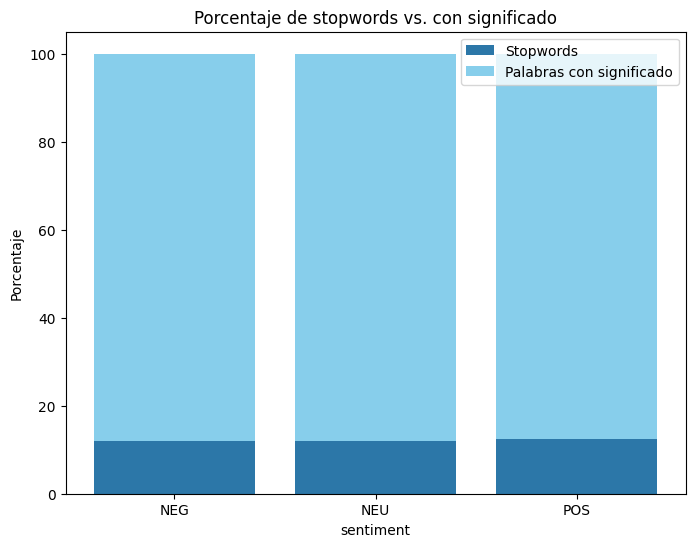

In [12]:
process_text_column2(df, 'review')
graphics_stopwords(df, 'sentiment')

Podemos ver como el porcentaje de stopwords es de alrededor del 10-15%

In [ ]:
pat = '[{}]'.format(re.escape(string.punctuation))

def normalize_document_remove_punct(doc, lemmatize=True):
    doc = re.sub(r'\d+', '', doc)
    tokens = nlp(doc)

    if lemmatize:
        filtered_tokens = [re.sub(pat, ' ', t.lemma_.lower())
                           for t in tokens
                           if not t.is_stop
                           and not t.is_punct
                           and not t.is_space]
    else:
        filtered_tokens = [re.sub(pat, ' ', t.text.lower())
                           for t in tokens
                           if not t.is_stop
                           and not t.is_punct
                           and not t.is_space]

    doc = ' '.join(filtered_tokens)
    return doc

df['review_lem'] = df['review'].apply(lambda x: normalize_document_remove_punct(x, lemmatize=True))
df['review_no_lem'] = df['review'].apply(lambda x: normalize_document_remove_punct(x, lemmatize=False))

In [14]:
df = df[['movie', 'username', 'date', 'score', 'review', 'review_lem', 'review_no_lem', 'sentiment', 'stopword_percentage']]
df

,movie,username,date,score,review,review_lem,review_no_lem,sentiment,stopword_percentage
0,Moonlight 2016,Randomsquirrel,"Jan 15, 2025",10,It was an absolutely brilliant film. Character...,absolutely brilliant film character deep plot ...,absolutely brilliant film characters deep plot...,POS,16.875000
3,Moonlight 2016,NWR1,"Mar 31, 2024",9,I haven’t felt this much emotion in a long tim...,feel emotion long time chiron manifest emotion...,felt emotion long time chiron manifested emoti...,POS,12.867647
5,Moonlight 2016,Youngoth,"Oct 16, 2023",10,"This movie is masterpiece, so well done. Deser...",movie masterpiece deserve oscar,movie masterpiece deserves oscars,POS,10.294118
6,Moonlight 2016,Dominik08,"Aug 15, 2023",8,"A refined production, with no obvious weakness...",refined production obvious weakness base ratio...,refined production obvious weaknesses based ra...,POS,13.333333
7,Moonlight 2016,AgentLvi,"Jun 27, 2023",7,"Decent movie. The story is so --so, scoring is...",decent movie story so scoring great visual d...,decent movie story so scoring great visual d...,POS,13.131313
...,...,...,...,...,...,...,...,...,...
9948,The Hottie The Nottie,Annoymous1,"May 3, 2013",0,"You can make fun of it, laugh at it, and it is...",fun laugh excellent award garbage get razzie b...,fun laugh excellent awards garbage got razzie ...,NEG,15.264798
9949,The Hottie The Nottie,snowcold,"Dec 5, 2011",1,Let's just say that Paris Hilton in a bikini i...,let paris hilton bikini bright spot movie bori...,let paris hilton bikini bright spot movie bori...,NEG,13.375796
9950,The Hottie The Nottie,Kadeemluvmusic,"Aug 20, 2011",0,It's time for Paris Hilton to go back to Carls...,time paris hilton carls jr start make porno m...,time paris hilton carls jr start making porno...,NEG,10.765550
9951,The Hottie The Nottie,smijatov,"Dec 22, 2010",1,"This film easily fits into the ""worst of all t...",film easily fit bad time category ah painful w...,film easily fits worst times category ah painf...,NEG,11.637931


## Exploratorio

Aplicamos una tokenización a los datos, para separar las palabras que tenemos en tokens para poder estudiarlo de manera clara y concisa.

In [15]:
def process_text_column(df, text_column, lemmatizer=None):
    df['tokens'] = df[text_column].apply(nlp)
    return df

In [16]:
process_text_column(df, "review_lem")

,movie,username,date,score,review,review_lem,review_no_lem,sentiment,stopword_percentage,tokens
0,Moonlight 2016,Randomsquirrel,"Jan 15, 2025",10,It was an absolutely brilliant film. Character...,absolutely brilliant film character deep plot ...,absolutely brilliant film characters deep plot...,POS,16.875000,"(absolutely, brilliant, film, character, deep,..."
3,Moonlight 2016,NWR1,"Mar 31, 2024",9,I haven’t felt this much emotion in a long tim...,feel emotion long time chiron manifest emotion...,felt emotion long time chiron manifested emoti...,POS,12.867647,"(feel, emotion, long, time, chiron, manifest, ..."
5,Moonlight 2016,Youngoth,"Oct 16, 2023",10,"This movie is masterpiece, so well done. Deser...",movie masterpiece deserve oscar,movie masterpiece deserves oscars,POS,10.294118,"(movie, masterpiece, deserve, oscar)"
6,Moonlight 2016,Dominik08,"Aug 15, 2023",8,"A refined production, with no obvious weakness...",refined production obvious weakness base ratio...,refined production obvious weaknesses based ra...,POS,13.333333,"(refined, production, obvious, weakness, base,..."
7,Moonlight 2016,AgentLvi,"Jun 27, 2023",7,"Decent movie. The story is so --so, scoring is...",decent movie story so scoring great visual d...,decent movie story so scoring great visual d...,POS,13.131313,"(decent, movie, story, , so, scoring, great,..."
...,...,...,...,...,...,...,...,...,...,...
9948,The Hottie The Nottie,Annoymous1,"May 3, 2013",0,"You can make fun of it, laugh at it, and it is...",fun laugh excellent award garbage get razzie b...,fun laugh excellent awards garbage got razzie ...,NEG,15.264798,"(fun, laugh, excellent, award, garbage, get, r..."
9949,The Hottie The Nottie,snowcold,"Dec 5, 2011",1,Let's just say that Paris Hilton in a bikini i...,let paris hilton bikini bright spot movie bori...,let paris hilton bikini bright spot movie bori...,NEG,13.375796,"(let, paris, hilton, bikini, bright, spot, mov..."
9950,The Hottie The Nottie,Kadeemluvmusic,"Aug 20, 2011",0,It's time for Paris Hilton to go back to Carls...,time paris hilton carls jr start make porno m...,time paris hilton carls jr start making porno...,NEG,10.765550,"(time, paris, hilton, carls, jr, , start, mak..."
9951,The Hottie The Nottie,smijatov,"Dec 22, 2010",1,"This film easily fits into the ""worst of all t...",film easily fit bad time category ah painful w...,film easily fits worst times category ah painf...,NEG,11.637931,"(film, easily, fit, bad, time, category, ah, p..."


In [17]:
df.to_csv("data/df_final_de_verdad.csv", index=False)

Podemos graficar la distribución de longitud de textos para cada clase.

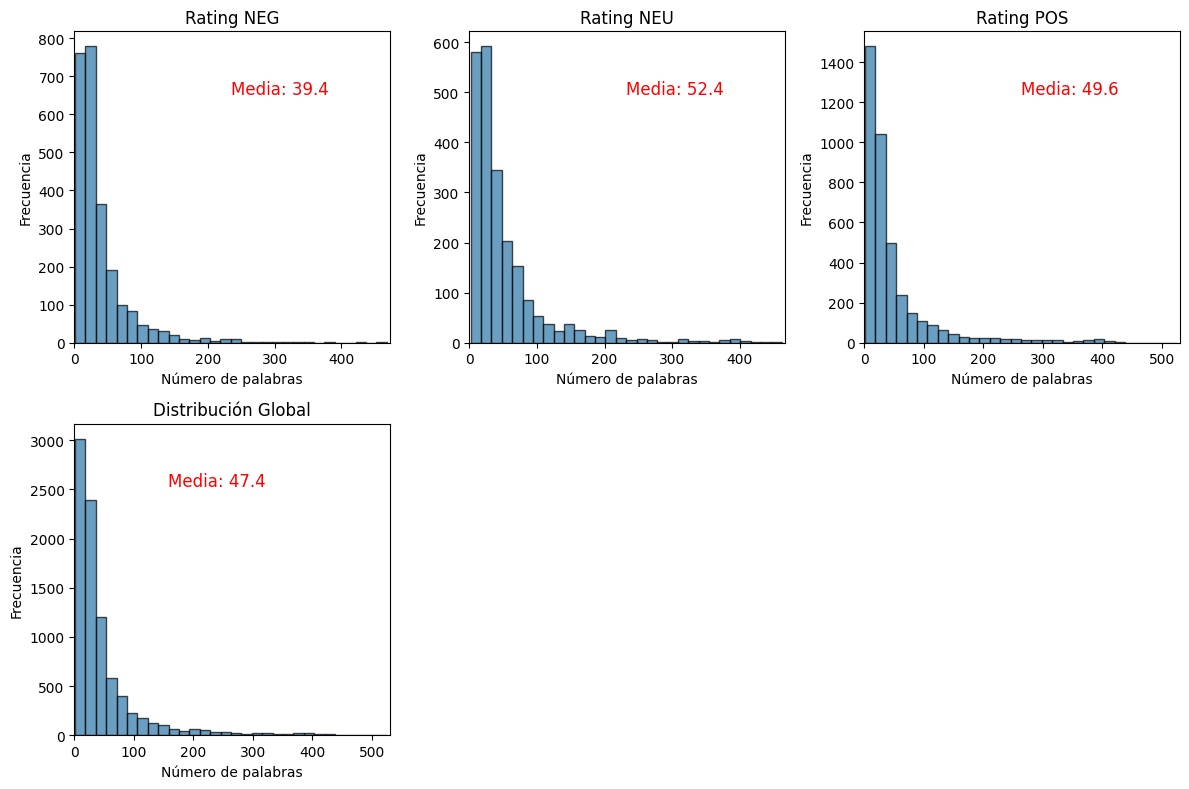

In [ ]:
def graficar_longitud_textos(df, text_column, rating_column):
    df['NP'] = df[text_column].apply(len)

    ratings = sorted(df[rating_column].unique())
    num_ratings = len(ratings)
    num_cols = min(3, num_ratings + 1)
    num_rows = (num_ratings + 1 + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows))
    axes = np.ravel(axes)

    for i, rating in enumerate(ratings):
        ax = axes[i]
        subset = df[df[rating_column] == rating]
        media_np = subset['NP'].mean()
        max_np = subset['NP'].max()

        ax.hist(subset['NP'], bins=30, edgecolor='black', alpha=0.7, color='#2C77A8')
        ax.set_xlim(0, max_np + 5)  
        ax.set_xlabel('Número de palabras')
        ax.set_ylabel('Frecuencia')
        ax.set_title(f'Rating {rating}')

        ax.text(max_np * 0.5, ax.get_ylim()[1] * 0.8, f'Media: {media_np:.1f}', fontsize=12, color='red')

    global_ax = axes[num_ratings]
    media_global = df['NP'].mean()
    max_np_global = df['NP'].max()

    global_ax.hist(df['NP'], bins=30, edgecolor='black', alpha=0.7, color='#2C77A8')
    global_ax.set_xlim(0, max_np_global + 5)
    global_ax.set_xlabel('Número de palabras')
    global_ax.set_ylabel('Frecuencia')
    global_ax.set_title('Distribución Global')
    global_ax.text(max_np_global * 0.3, global_ax.get_ylim()[1] * 0.8, f'Media: {media_global:.1f}', fontsize=12, color='red')

    for j in range(num_ratings + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

graficar_longitud_textos(df, 'tokens', 'sentiment')

Vemos como la mayoría de los textos tienen una longitud parecida para cada clase, la cuál refiere a unas 30-40 palabras por cada reseña, lo cuál nos va a ayudar a saber como se van a aplicar los word embeddings y los distintos modelos a los datos

Para ver las palabras más repetidas por vcada clase obtenemos los wordclouds

C:\Users\Juanjo\AppData\Local\Temp\ipykernel_3908\2877567889.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return diff_scores.fillna(0)


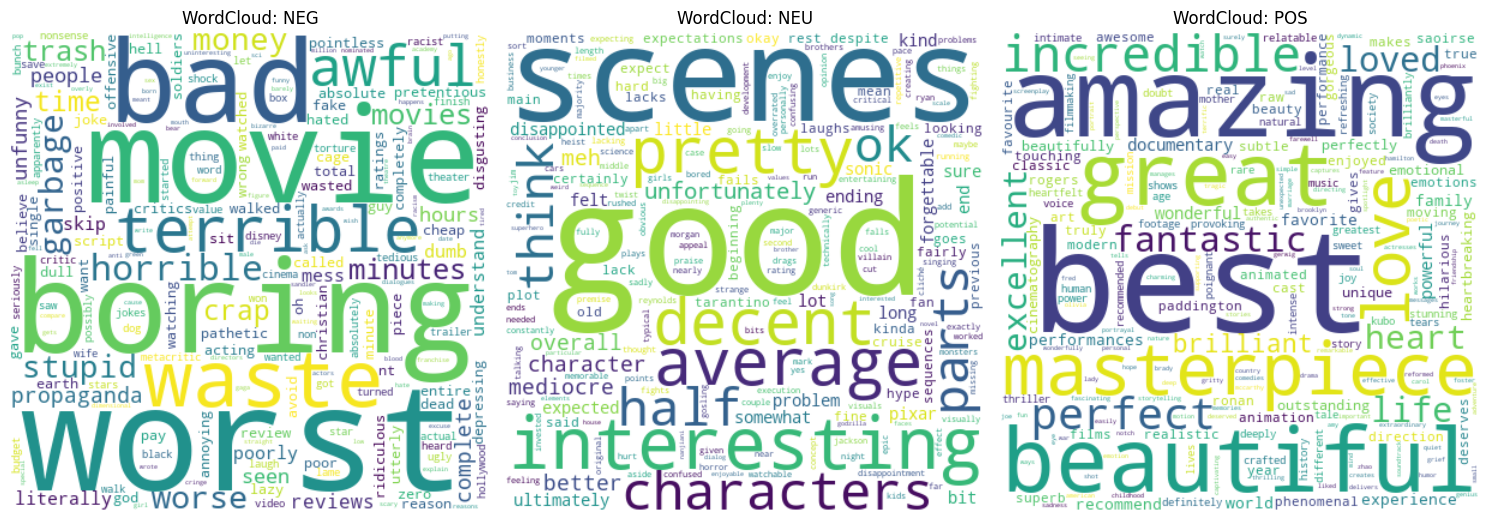

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=1500)
X = vectorizer.fit_transform(df['review_no_lem'])
words = vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(X.toarray(), columns=words)
tfidf_df['sentiment'] = df['sentiment'].values

mean_tfidf_per_class = tfidf_df.groupby('sentiment').mean()

def differential_score(df_means):
    diff_scores = pd.DataFrame(index=df_means.index, columns=df_means.columns)
    for cat in df_means.index:
        for word in df_means.columns:
            val_in_cat = df_means.loc[cat, word]
            val_in_others = df_means.drop(cat)[word].max()
            diff_scores.loc[cat, word] = val_in_cat - val_in_others
    return diff_scores.fillna(0)

diff_scores = differential_score(mean_tfidf_per_class)

distinctive_words = {}
for cat in diff_scores.index:
    positive_scores = diff_scores.loc[cat][diff_scores.loc[cat] > 0]
    sorted_words_scores = positive_scores.sort_values(ascending=False)
    distinctive_words[cat] = sorted_words_scores

plt.figure(figsize=(15, 8))

for i, (cat, scores) in enumerate(distinctive_words.items()):

    word_freq = scores.to_dict()

    plt.subplot(1, len(distinctive_words), i + 1)
    wc = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(word_freq)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud: {cat}')

plt.tight_layout()
plt.show()


In [ ]:
def get_ngrams(tokens, n):
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [' '.join(ngram) for ngram in ngrams]

def plot_most_common_ngrams_by_class(df, text_column, class_column):

    num_classes = len(df[class_column].unique())
    ncols = 3  
    nrows = (num_classes + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
    axes = axes.flatten()  

    for i, class_value in enumerate(df[class_column].unique()):

        df['tokens'] = df['tokens'].apply(lambda x: [t.text if hasattr(t, "text") else str(t) for t in x] if isinstance(x, list) else str(x).split())

        subset = df[df[class_column] == class_value]

        all_words = [word for tokens in subset[text_column] for word in tokens]

        bigram_freq = Counter(get_ngrams(all_words, 2))
        bigram_most_common = bigram_freq.most_common(10)
        bigrams, bigram_counts = zip(*bigram_most_common)
        
        axes[i].barh(bigrams, bigram_counts, color='#a9dfd0', alpha=0.7)
        axes[i].set_title(f'Bigramas más comunes en {class_value}')
        axes[i].set_xlabel('Frecuencia')
        axes[i].set_ylabel('Bigramas')

    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
    axes = axes.flatten()  

    # Generar trigramas
    for i, class_value in enumerate(df[class_column].unique()):
        subset = df[df[class_column] == class_value]

        all_words = [word for tokens in subset[text_column] for word in tokens]

        trigram_freq = Counter(get_ngrams(all_words, 3))
        trigram_most_common = trigram_freq.most_common(10)
        trigrams, trigram_counts = zip(*trigram_most_common)

        axes[i].barh(trigrams, trigram_counts, color='#2C77A8', alpha=0.7)
        axes[i].set_title(f'Trigramas más comunes en {class_value}')
        axes[i].set_xlabel('Frecuencia')
        axes[i].set_ylabel('Trigramas')

    plt.tight_layout()
    plt.show()

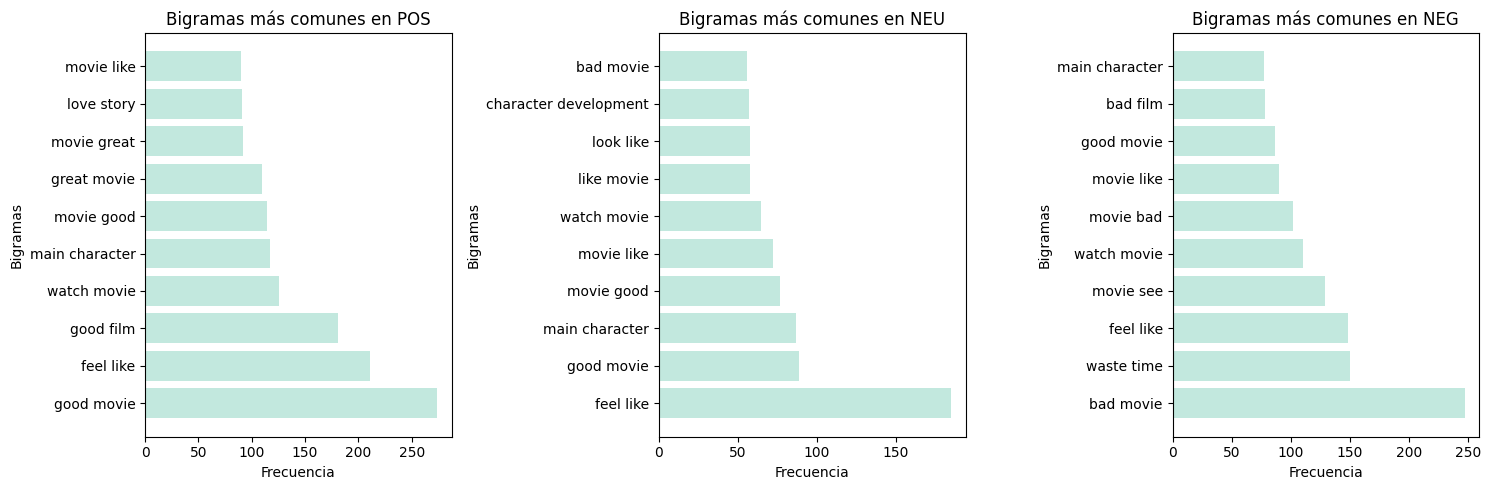

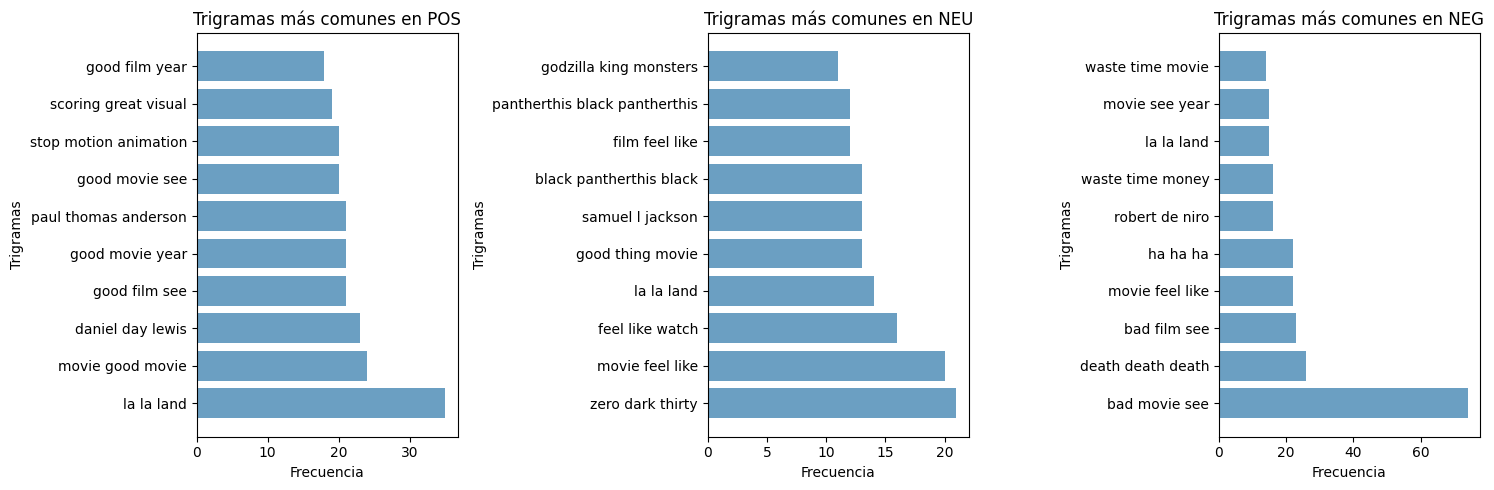

In [23]:
plot_most_common_ngrams_by_class(df, "tokens", "sentiment")

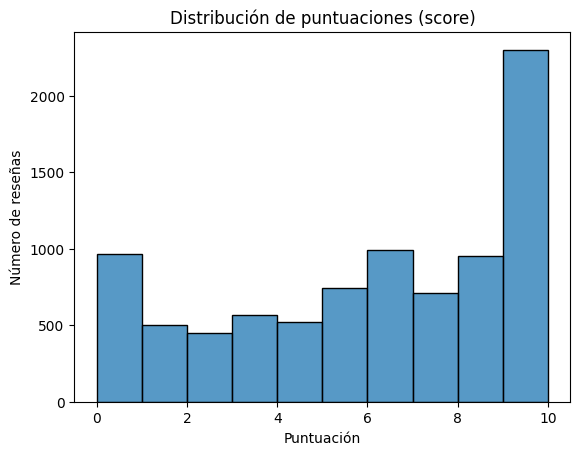

In [ ]:
sns.histplot(df['score'].astype(int), bins=10, kde=False)
plt.title('Distribución de puntuaciones (score)')
plt.xlabel('Puntuación')
plt.ylabel('Número de reseñas')
plt.show()

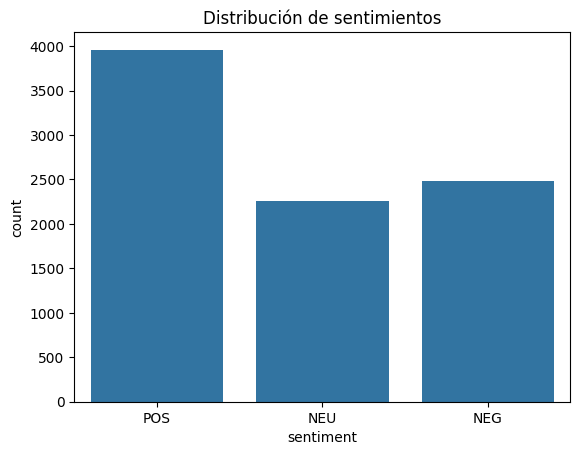

In [26]:
sns.countplot(data=df, x='sentiment')
plt.title('Distribución de sentimientos')
plt.show()

## Extracción de características

### Separación en train y test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df['review_lem'], df['sentiment'], test_size=0.2, random_state=42)

In [ ]:
X_train_no_lem, X_test_no_lem, y_train_no_lem, y_test_no_lem = train_test_split(
    df['review_no_lem'], df['sentiment'], test_size=0.2, random_state=42)

### Embeddings Sparse

#### TF-IDF

In [28]:
vectorizer = TfidfVectorizer()
vectorizer.fit(df['review_lem'])

print("Número total de palabras únicas:", len(vectorizer.vocabulary_))

Número total de palabras únicas: 22814


In [ ]:
#Vectorizador solo con los datos de entrenamiento
tfidf = TfidfVectorizer(max_features=1000)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

### Embeddings densos

##### GLOVE

In [ ]:
glove_file_path = 'data/glove.twitter.27B.50d.txt'

#diccionario GLOVE
glove_dict = {}

with open(glove_file_path, 'r', encoding='utf-8') as f:
    for line in f:
        # Separar cada línea en la palabra y el vector
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_dict[word] = vector

print(f"Se han cargado {len(glove_dict)} palabras en el diccionario de GloVe.")

Se han cargado 1193514 palabras en el diccionario de GloVe.


In [ ]:
#Convertir una reseña en un vector
def text_to_vector(text, glove_dict, dim=50):
    words = text.split()  

    valid_vectors = [glove_dict[word] for word in words if word in glove_dict]

    # si hay palabras válidas, calcular la media de los vectores
    if valid_vectors:
        return np.mean(valid_vectors, axis=0)
    else:
        # si no, devuelve un vector de ceros
        return np.zeros(dim)

X_glove = np.vstack(df['review_lem'].apply(lambda x: text_to_vector(x, glove_dict)))
print(X_glove.shape)

(8696, 50)


In [ ]:
X_train_glove, X_test_glove, y_train, y_test = train_test_split(
    X_glove, df['sentiment'], test_size=0.2, random_state=42)

##### BERT

In [ ]:
model_bert = SentenceTransformer('all-mpnet-base-v2')

In [ ]:
X_train_bert = model_bert.encode(X_train_no_lem.tolist(), convert_to_numpy=True)
X_test_bert = model_bert.encode(X_test_no_lem.tolist(), convert_to_numpy=True)

## Modelos de clasificación (no preentrenados)

### Embedding Sparse 

#### TF-IDF + LR

In [36]:
le = LabelEncoder()

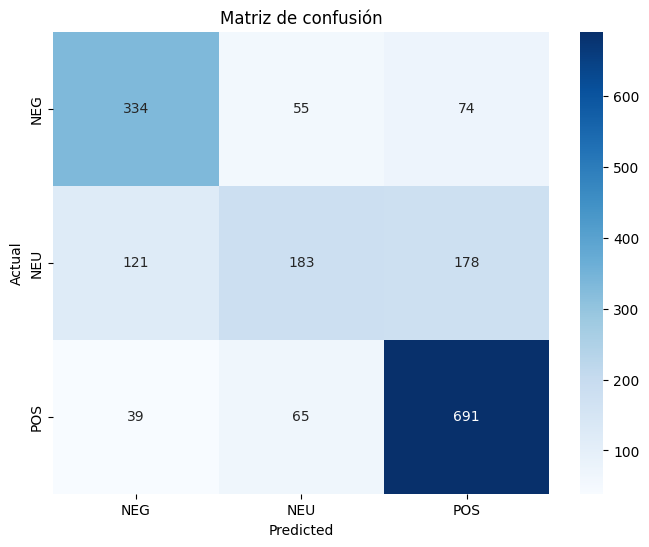

              precision    recall  f1-score   support

         NEG       0.68      0.72      0.70       463
         NEU       0.60      0.38      0.47       482
         POS       0.73      0.87      0.80       795

    accuracy                           0.69      1740
   macro avg       0.67      0.66      0.65      1740
weighted avg       0.68      0.69      0.68      1740



In [37]:
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

modelLR = LogisticRegression(solver='liblinear')

modelLR.fit(X_train_vec, y_train_enc)
prediccion_vec = modelLR.predict(X_test_vec)

cm_vec = confusion_matrix(y_test_enc, prediccion_vec)

plt.figure(figsize=(8,6))
sns.heatmap(cm_vec, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de confusión')
plt.show()

print(classification_report(y_test_enc, prediccion_vec, target_names=le.classes_))

In [ ]:
errores_df = pd.DataFrame({
    'review': X_test.tolist(),
    'true_label': le.inverse_transform(y_test_enc),
    'predicted_label': le.inverse_transform(prediccion_vec)
})

#### TF-IDF + Topic Modeling (LSA) + LR

In [ ]:
# LSA - ajustar sobre el TF-IDF del train
lsa = TruncatedSVD(n_components=15, random_state=42)
X_train_topic = lsa.fit_transform(X_train_vec)
X_test_topic = lsa.transform(X_test_vec)

modelLR.fit(X_train_topic, y_train_enc)

y_pred_topic = modelLR.predict(X_test_topic)
print(classification_report(y_test_enc, y_pred_topic, target_names=le.classes_))

              precision    recall  f1-score   support

         NEG       0.57      0.60      0.59       463
         NEU       0.50      0.12      0.19       482
         POS       0.62      0.89      0.73       795

    accuracy                           0.60      1740
   macro avg       0.57      0.54      0.50      1740
weighted avg       0.57      0.60      0.54      1740



#### TF-IDF + Topic Modeling (LSA) + XGB

In [ ]:
le2 = LabelEncoder()

# XGBoost
modelXGB = XGBClassifier(
    objective='multi:softprob',  
    num_class=len(le.classes_), 
    eval_metric='mlogloss',     
    use_label_encoder=False,
    random_state=42
)

# entrenar 
modelXGB.fit(X_train_topic, y_train_enc)

# predecir 
prediccion_xgb = modelXGB.predict(X_test_topic)

print(classification_report(y_test_enc, prediccion_xgb, target_names=le2.classes_))

c:\Users\Juanjo\.conda\envs\spacy-env\lib\site-packages\xgboost\training.py:183: UserWarning: [13:48:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

         NEG       0.58      0.63      0.60       463
         NEU       0.44      0.29      0.35       482
         POS       0.66      0.76      0.71       795

    accuracy                           0.60      1740
   macro avg       0.56      0.56      0.55      1740
weighted avg       0.58      0.60      0.58      1740



### Embedding densos

#### GLOVE  + LR

In [ ]:
# Crear y entrenar el clasificador
modelLR2 = LogisticRegression(solver='liblinear')
modelLR2.fit(X_train_glove, y_train_enc)

# Realizar predicciones
prediccion_glove = modelLR2.predict(X_test_glove)

# Evaluar el modelo
print(classification_report(y_test_enc, prediccion_glove, target_names=le.classes_))

              precision    recall  f1-score   support

         NEG       0.59      0.71      0.65       463
         NEU       0.54      0.19      0.28       482
         POS       0.66      0.84      0.74       795

    accuracy                           0.63      1740
   macro avg       0.60      0.58      0.55      1740
weighted avg       0.61      0.63      0.59      1740



#### BERT  + LR


In [ ]:
le3 = LabelEncoder()
y_train_enc_no_lem = le.fit_transform(y_train_no_lem)
y_test_enc_no_lem = le.transform(y_test_no_lem)

modelLR3 = LogisticRegression(solver='liblinear')
modelLR3.fit(X_train_bert, y_train_enc_no_lem)
prediccion_bert = modelLR3.predict(X_test_bert)

print(classification_report(y_test_enc_no_lem, prediccion_bert, target_names=le3.classes_))

              precision    recall  f1-score   support

         NEG       0.65      0.76      0.70       463
         NEU       0.57      0.31      0.40       482
         POS       0.73      0.87      0.80       795

    accuracy                           0.69      1740
   macro avg       0.65      0.65      0.63      1740
weighted avg       0.67      0.69      0.66      1740



Con parámetro ``class_weight=balanced``

In [43]:
clf = LogisticRegression(class_weight='balanced', solver='liblinear')
clf.fit(X_train_bert, y_train_enc_no_lem)
prediccion_bert2 = clf.predict(X_test_bert)

print(classification_report(y_test_enc_no_lem, prediccion_bert2, target_names=le.classes_))


              precision    recall  f1-score   support

         NEG       0.66      0.77      0.71       463
         NEU       0.56      0.41      0.47       482
         POS       0.78      0.83      0.80       795

    accuracy                           0.70      1740
   macro avg       0.67      0.67      0.66      1740
weighted avg       0.69      0.70      0.69      1740



## Modelo preentrenado (pipeline análisis de sentimientos)

In [ ]:
#carga de la pipeline preentrenada
classifier = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

#mapeo
model_to_custom_label = {
    "LABEL_0": "NEG",
    "LABEL_1": "NEU",
    "LABEL_2": "POS"
}

max_len = 512

def predecir_sentimiento(textos):
    textos_recortados = [t[:max_len] for t in textos]
    resultados = classifier(textos_recortados)
    etiquetas_pred = [model_to_custom_label[r['label']] for r in resultados]
    return etiquetas_pred

y_pred_pipeline = predecir_sentimiento(X_test_no_lem.tolist())
print(classification_report(y_test_no_lem, y_pred_pipeline, digits=4))


Device set to use cpu


              precision    recall  f1-score   support

         NEG     0.6259    0.7192    0.6693       463
         NEU     0.3830    0.3465    0.3638       482
         POS     0.7267    0.7057    0.7160       795

    accuracy                         0.6098      1740
   macro avg     0.5786    0.5905    0.5831      1740
weighted avg     0.6047    0.6098    0.6060      1740



## Análisis malas clasificaciones

In [ ]:
errores_df_filtered = errores_df[errores_df['true_label'] != errores_df['predicted_label']]
errores_filtered_neu = errores_df_filtered[errores_df_filtered['true_label'] == 'NEU']

for _, row in errores_filtered_neu.sample(10, random_state=42).iterrows():
    print("-" * 80)
    print(f"REVIEW:\n{row['review']}\n")
    print(f"True label: {row['true_label']} | Predicted label: {row['predicted_label']}")

--------------------------------------------------------------------------------
REVIEW:
heavily kenneth branagh star shakespeare return home globe theatre burn attempt deal death son try mend relationship wife judi dench remain daughter film capture period beautiful cinematography quiet pace extend wide shot dialogue sluggish tempo allow plenty time absorb mise en scene strain interest performance interesting story present fascinating bard life objective approach thank partially director branagh keep film grab hold

True label: NEU | Predicted label: POS
--------------------------------------------------------------------------------
REVIEW:
shame filmmaker age waste time effort invent character compose dialog develop story patch action scene instruct thespian ad lib grunt shout movie mean story series anecdote studs terkel oral history newsreel footage substitute word watch watch film character story mrs  miniver

True label: NEU | Predicted label: NEG
-------------------------------

Posibles explicaciones del error en la etiqueta:

- Etiquetado humano inconsistente o erróneo
Muchos datasets de texto etiquetados manualmente (como los de reseñas) sufren de inconsistencias. Una persona pudo haber considerado esa reseña como "neutral" por alguna razón subjetiva, aunque objetivamente parezca positiva.

- Etiquetado automático poco preciso
Si el dataset fue etiquetado automáticamente con otro modelo, puede haber errores sistemáticos.

- Frases ambiguas o irónicas
En frases muy breves, como esta, el etiquetador pudo interpretar falta de información emocional explícita y asignar un "NEU", aunque haya un tono implícitamente positivo.

## Eliminación de neutras

In [ ]:
df_sin_neu = df.copy()

# eliminar las filas con sentimiento 'NEU'
df_sin_neu = df_sin_neu[df_sin_neu['sentiment'] != 'NEU']

In [46]:
# Separar para clasificación de sentimiento
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    df_sin_neu['review'], df_sin_neu['sentiment'], test_size=0.2, random_state=42)

In [47]:
# Separar para clasificación
X_train_no_lem2, X_test_no_lem2, y_train_no_lem2, y_test_no_lem2 = train_test_split(
    df_sin_neu['review_no_lem'], df_sin_neu['sentiment'], test_size=0.2, random_state=42)

### TF-IDF + LR

In [52]:
tfidf = TfidfVectorizer(max_features=1500)
X_train_vec2 = tfidf.fit_transform(X_train2)
X_test_vec2 = tfidf.transform(X_test2)

In [ ]:
le4 = LabelEncoder()
y_train_enc2 = le.fit_transform(y_train2)
y_test_enc2 = le.transform(y_test2)

modelLR4 = LogisticRegression(solver='liblinear')
modelLR4.fit(X_train_vec2, y_train_enc2)
prediccion_vec2 = modelLR4.predict(X_test_vec2)

print(classification_report(y_test_enc2, prediccion_vec2, target_names=le4.classes_))

              precision    recall  f1-score   support

         NEG       0.90      0.78      0.83       482
         POS       0.88      0.95      0.91       807

    accuracy                           0.88      1289
   macro avg       0.89      0.86      0.87      1289
weighted avg       0.88      0.88      0.88      1289



### BERT + LR

In [ ]:
X_train_bert2 = model_bert.encode(X_train_no_lem2.tolist(), convert_to_numpy=True)
X_test_bert2 = model_bert.encode(X_test_no_lem2.tolist(), convert_to_numpy=True)

In [ ]:
le5 = LabelEncoder()
y_train_enc2_no_lem = le.fit_transform(y_train_no_lem2)
y_test_enc2_no_lem = le.transform(y_test_no_lem2)

modelLR5 = LogisticRegression(solver='liblinear')
modelLR5.fit(X_train_bert2, y_train_enc2_no_lem)
prediccion_bert_2 = modelLR5.predict(X_test_bert2)

print(classification_report(y_test_enc2_no_lem, prediccion_bert_2, target_names=le5.classes_))

              precision    recall  f1-score   support

         NEG       0.85      0.81      0.83       482
         POS       0.89      0.91      0.90       807

    accuracy                           0.87      1289
   macro avg       0.87      0.86      0.86      1289
weighted avg       0.87      0.87      0.87      1289



### Coherencia

In [ ]:
nltk.download('punkt_tab')

#función para calcular el score de sentimiento a través de textbolb
def expand_reviews_with_sentiment(df):
    rows = []

    for idx, row in df.iterrows():
        review = row["review"]
        movie = row["movie"]

        sentences = sent_tokenize(review)
        for sent in sentences:

            polarity = TextBlob(sent).sentiment.polarity
            rows.append({
                "original_index": idx,
                "movie": movie,
                "sentence": sent,
                "sentiment_score": polarity
            })

    return pd.DataFrame(rows)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Juanjo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [60]:
df_resultado = expand_reviews_with_sentiment(df)

In [ ]:
# calcular media de sentimientos por reseña
mean_score = df_resultado.groupby("original_index")["sentiment_score"].agg(lambda x: x.mean())

df['mean_score'] = df.index.map(mean_score)
print(df[['review', 'mean_score']].head())

                                              review  mean_score
0  It was an absolutely brilliant film. Character...    0.456250
3  I haven’t felt this much emotion in a long tim...    0.180000
5  This movie is masterpiece, so well done. Deser...    0.250000
6  A refined production, with no obvious weakness...    0.000000
7  Decent movie. The story is so --so, scoring is...    0.304167


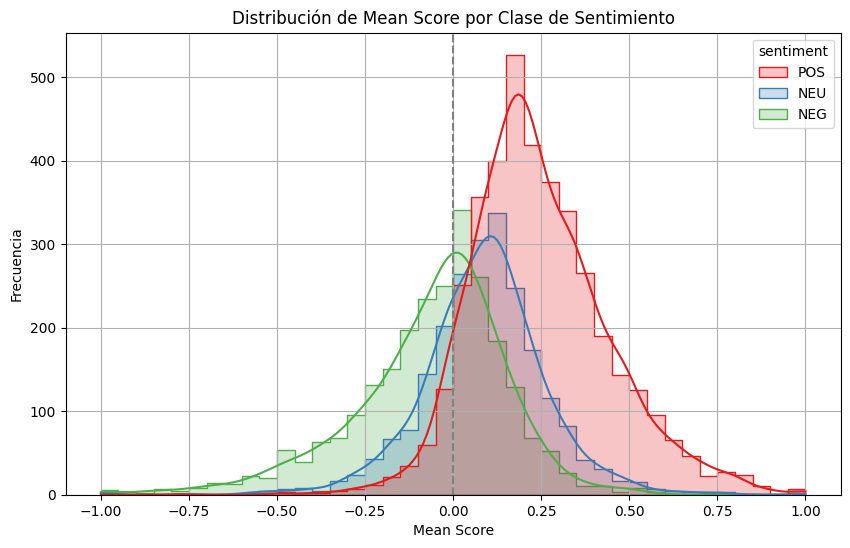

In [ ]:
plt.figure(figsize=(10, 6))

sns.histplot(
    data=df,
    x="mean_score",
    hue="sentiment",           
    kde=True,                 
    bins=40,
    palette="Set1",
    element="step",           
    common_norm=False
)

plt.axvline(x=0, color='gray', linestyle='--', label='score = 0')
plt.title("Distribución de Mean Score por Clase de Sentimiento")
plt.xlabel("Mean Score")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()


In [ ]:
df_filtrado = df[
    ((df['sentiment'] == 'POS') & (df['mean_score'] >= 0.1)) |
    ((df['sentiment'] == 'NEG') & (df['mean_score'] <= -0.1)) |
    ((df['sentiment'] == 'NEU') & (df['mean_score'] > -0.3) & (df['mean_score'] < 0.3))
]

In [ ]:
df_filtrado.head()

,Unnamed: 0,movie,username,date,score,review,review_lem,review_no_lem,sentiment,stopword_percentage,mean_score
0,0,Moonlight 2016,Randomsquirrel,"Jan 15, 2025",10,It was an absolutely brilliant film. Character...,absolutely brilliant film character deep plot ...,absolutely brilliant film characters deep plot...,POS,16.875000,0.456250
1,3,Moonlight 2016,NWR1,"Mar 31, 2024",9,I haven’t felt this much emotion in a long tim...,feel emotion long time chiron manifest emotion...,felt emotion long time chiron manifested emoti...,POS,12.867647,0.180000
2,5,Moonlight 2016,Youngoth,"Oct 16, 2023",10,"This movie is masterpiece, so well done. Deser...",movie masterpiece deserve oscar,movie masterpiece deserves oscars,POS,10.294118,0.250000
4,7,Moonlight 2016,AgentLvi,"Jun 27, 2023",7,"Decent movie. The story is so --so, scoring is...",decent movie story so scoring great visual d...,decent movie story so scoring great visual d...,POS,13.131313,0.304167
5,8,Moonlight 2016,shumat,"Feb 3, 2023",8,very good film i fully reccomend it for everyb...,good film fully reccomend everybody like actio...,good film fully reccomend everybody likes acti...,POS,11.650485,0.536667


In [65]:
df_filtrado['sentiment'].value_counts()

sentiment
POS    3092
NEU    1996
NEG     898
Name: count, dtype: int64

In [67]:
df_filtrado

,movie,username,date,score,review,review_lem,review_no_lem,sentiment,stopword_percentage,tokens,NP,mean_score
0,Moonlight 2016,Randomsquirrel,"Jan 15, 2025",10,It was an absolutely brilliant film. Character...,absolutely brilliant film character deep plot ...,absolutely brilliant film characters deep plot...,POS,16.875000,"[absolutely, brilliant, film, character, deep,...",13,0.456250
3,Moonlight 2016,NWR1,"Mar 31, 2024",9,I haven’t felt this much emotion in a long tim...,feel emotion long time chiron manifest emotion...,felt emotion long time chiron manifested emoti...,POS,12.867647,"[feel, emotion, long, time, chiron, manifest, ...",24,0.180000
5,Moonlight 2016,Youngoth,"Oct 16, 2023",10,"This movie is masterpiece, so well done. Deser...",movie masterpiece deserve oscar,movie masterpiece deserves oscars,POS,10.294118,"[movie, masterpiece, deserve, oscar]",4,0.250000
7,Moonlight 2016,AgentLvi,"Jun 27, 2023",7,"Decent movie. The story is so --so, scoring is...",decent movie story so scoring great visual d...,decent movie story so scoring great visual d...,POS,13.131313,"[decent, movie, story, so, scoring, great, vis...",11,0.304167
8,Moonlight 2016,shumat,"Feb 3, 2023",8,very good film i fully reccomend it for everyb...,good film fully reccomend everybody like actio...,good film fully reccomend everybody likes acti...,POS,11.650485,"[good, film, fully, reccomend, everybody, like...",10,0.536667
...,...,...,...,...,...,...,...,...,...,...,...,...
9948,The Hottie The Nottie,Annoymous1,"May 3, 2013",0,"You can make fun of it, laugh at it, and it is...",fun laugh excellent award garbage get razzie b...,fun laugh excellent awards garbage got razzie ...,NEG,15.264798,"[fun, laugh, excellent, award, garbage, get, r...",25,-0.339259
9949,The Hottie The Nottie,snowcold,"Dec 5, 2011",1,Let's just say that Paris Hilton in a bikini i...,let paris hilton bikini bright spot movie bori...,let paris hilton bikini bright spot movie bori...,NEG,13.375796,"[let, paris, hilton, bikini, bright, spot, mov...",12,-0.150000
9950,The Hottie The Nottie,Kadeemluvmusic,"Aug 20, 2011",0,It's time for Paris Hilton to go back to Carls...,time paris hilton carls jr start make porno m...,time paris hilton carls jr start making porno...,NEG,10.765550,"[time, paris, hilton, carls, jr, start, make, ...",37,-0.130000
9951,The Hottie The Nottie,smijatov,"Dec 22, 2010",1,"This film easily fits into the ""worst of all t...",film easily fit bad time category ah painful w...,film easily fits worst times category ah painf...,NEG,11.637931,"[film, easily, fit, bad, time, category, ah, p...",34,-0.306481


In [ ]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(
    df_filtrado['review_lem'], df_filtrado['sentiment'], test_size=0.2, random_state=42)

In [ ]:
X_train_no_lem3, X_test_no_lem3, y_train_no_lem3, y_test_no_lem3 = train_test_split(
    df_filtrado['review_no_lem'], df_filtrado['sentiment'], test_size=0.2, random_state=42)

### TF-IDF + LR

In [ ]:
tfidf2 = TfidfVectorizer(max_features=1500)
X_train_vec3 = tfidf2.fit_transform(X_train3)
X_test_vec3 = tfidf2.transform(X_test3)

In [ ]:
le6 = LabelEncoder()
y_train_enc3 = le6.fit_transform(y_train3)
y_test_enc3 = le6.transform(y_test3)

modelLR6 = LogisticRegression(solver='liblinear')
modelLR6.fit(X_train_vec3, y_train_enc3)
prediccion_vec3 = modelLR6.predict(X_test_vec3)

print(classification_report(y_test_enc3, prediccion_vec3, target_names=le6.classes_))

              precision    recall  f1-score   support

         NEG       0.87      0.74      0.80       169
         NEU       0.80      0.65      0.72       405
         POS       0.81      0.94      0.87       624

    accuracy                           0.81      1198
   macro avg       0.83      0.78      0.80      1198
weighted avg       0.81      0.81      0.81      1198



### BERT + LR

In [ ]:
X_train_bert3 = model_bert.encode(X_train_no_lem3.tolist(), convert_to_numpy=True)
X_test_bert3 = model_bert.encode(X_test_no_lem3.tolist(), convert_to_numpy=True)

In [ ]:
le7 = LabelEncoder()
y_train_enc3 = le.fit_transform(y_train_no_lem3)
y_test_enc3 = le.transform(y_test_no_lem3)

modelLR7 = LogisticRegression(solver='liblinear')
modelLR7.fit(X_train_bert3, y_train_enc3)
prediccion3_bert = modelLR.predict(X_test_bert3)

print(classification_report(y_test_enc3, prediccion3_bert, target_names=le7.classes_))

              precision    recall  f1-score   support

         NEG       0.84      0.71      0.77       172
         NEU       0.68      0.63      0.65       378
         POS       0.82      0.89      0.86       648

    accuracy                           0.78      1198
   macro avg       0.78      0.74      0.76      1198
weighted avg       0.78      0.78      0.78      1198



## Modelos de estimación por score

#### TF-IDF + LR

In [72]:
X_train_score, X_test_score, y_train_score, y_test_score = train_test_split(
    df['review_lem'], df['score'], test_size=0.2, random_state=42)

In [73]:
X_train_score_vec = tfidf.fit_transform(X_train_score)
X_test_score_vec = tfidf.transform(X_test_score)

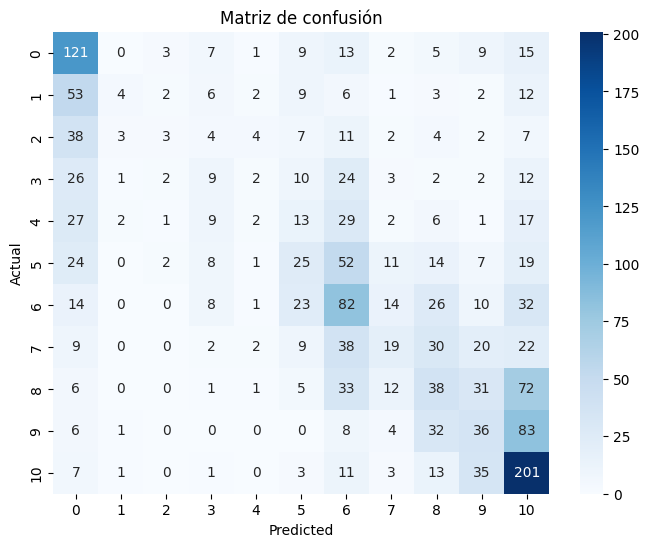

              precision    recall  f1-score   support

           0       0.37      0.65      0.47       185
           1       0.33      0.04      0.07       100
           2       0.23      0.04      0.06        85
           3       0.16      0.10      0.12        93
           4       0.12      0.02      0.03       109
           5       0.22      0.15      0.18       163
           6       0.27      0.39      0.32       210
           7       0.26      0.13      0.17       151
           8       0.22      0.19      0.20       199
           9       0.23      0.21      0.22       170
          10       0.41      0.73      0.52       275

    accuracy                           0.31      1740
   macro avg       0.26      0.24      0.22      1740
weighted avg       0.27      0.31      0.26      1740



In [ ]:
le8 = LabelEncoder()
y_train_score_enc = le8.fit_transform(y_train_score)
y_test_score_enc = le8.transform(y_test_score)

modelLR8 = LogisticRegression(solver='liblinear')
modelLR8.fit(X_train_score_vec, y_train_score_enc)
prediccion_score = modelLR8.predict(X_test_score_vec)

cm_score = confusion_matrix(y_test_score_enc, prediccion_score)

plt.figure(figsize=(8,6))
sns.heatmap(cm_score, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de confusión')
plt.show()

print(classification_report(y_test_score_enc, prediccion_score, target_names=[str(c) for c in le.classes_]))

#### BERT + LR

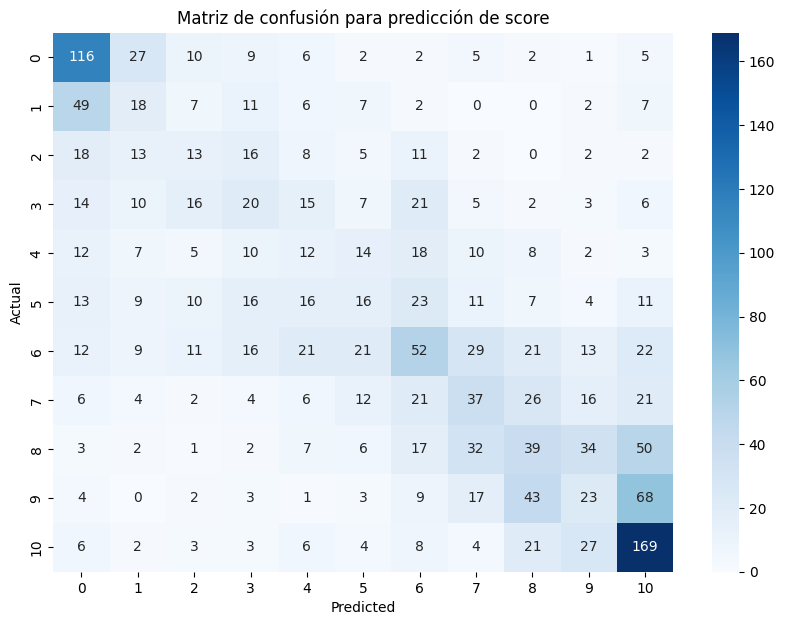

              precision    recall  f1-score   support

           0       0.46      0.63      0.53       185
           1       0.18      0.17      0.17       109
           2       0.16      0.14      0.15        90
           3       0.18      0.17      0.17       119
           4       0.12      0.12      0.12       101
           5       0.16      0.12      0.14       136
           6       0.28      0.23      0.25       227
           7       0.24      0.24      0.24       155
           8       0.23      0.20      0.22       193
           9       0.18      0.13      0.15       173
          10       0.46      0.67      0.55       253

    accuracy                           0.30      1741
   macro avg       0.24      0.26      0.24      1741
weighted avg       0.27      0.30      0.28      1741



In [ ]:
X_train_score2, X_test_score2, y_train_score2, y_test_score2 = train_test_split(
    df['review_no_lem'], df['score'], test_size=0.2, random_state=42
)

le9 = LabelEncoder()
y_train_score_enc2 = le9.fit_transform(y_train_score2)
y_test_score_enc2 = le9.transform(y_test_score2)

X_train_bert2 = model_bert.encode(X_train_score2.tolist(), convert_to_numpy=True)
X_test_bert2 = model_bert.encode(X_test_score2.tolist(), convert_to_numpy=True)

clf2 = LogisticRegression(class_weight='balanced', solver='liblinear', max_iter=1000)
clf2.fit(X_train_bert2, y_train_score_enc2)

y_pred_score2 = clf.predict(X_test_bert2)

cm_score2 = confusion_matrix(y_test_score_enc, y_pred_score2)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_score2, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de confusión para predicción de score')
plt.show()

print(classification_report(y_test_score_enc, y_pred_score2, target_names=le9.classes_.astype(str)))


## Recomendador

Vamos a hacer un recomendador de películas para uno de los usuarios que han escrito sus reseñas en la página web. La idea del recomendador es basarse en el género de las películas que más le han gustado al usuario, lo cual vendrá determinado por la puntuación de la reseña (score).

El principal problema al que nos enfrentamos es que nuestro dataset de reseñas no incluye el género de las películas. Para poder incluirlo, descargamos un dataset de kaggle que contiene muchas películas de meta-critic y su género, entre otras características.

In [75]:
movies_df = pd.read_csv("data/16k_Movies.csv")
movies_df.head()

,Unnamed: 0,Title,Release Date,Description,Rating,No of Persons Voted,Directed by,Written by,Duration,Genres
0,0,Dekalog (1988),"Mar 22, 1996",This masterwork by Krzysztof Kieślowski is one...,7.4,118,Krzysztof Kieslowski,"Krzysztof Kieslowski, Krzysztof Piesiewicz",9 h 32 m,Drama
1,1,Three Colors: Red,"Nov 23, 1994",Krzysztof Kieslowski closes his Three Colors t...,8.3,241,Krzysztof Kieslowski,"Krzysztof Kieslowski, Krzysztof Piesiewicz, Ag...",1 h 39 m,"Drama,Mystery,Romance"
2,2,The Conformist,"Oct 22, 1970","Set in Rome in the 1930s, this re-release of B...",7.3,106,Bernardo Bertolucci,"Alberto Moravia, Bernardo Bertolucci",1 h 47 m,Drama
3,3,Tokyo Story,"Mar 13, 1972",Yasujiro Ozu’s Tokyo Story follows an aging co...,8.1,147,Yasujirô Ozu,"Kôgo Noda, Yasujirô Ozu",2 h 16 m,Drama
4,4,The Leopard (re-release),"Aug 13, 2004","Set in Sicily in 1860, Luchino Visconti's spec...",7.8,85,Luchino Visconti,"Giuseppe Tomasi di Lampedusa, Suso Cecchi D'Am...",3 h 7 m,"Drama,History"


Una vez cargado el dataset, le modificamos la estructura para que tenga por columnas todos los géneros posibles y por filas las películas, de forma que cada película tenga un 1 en una columna si la película pertenece a un género y un 0 en otro caso.

In [ ]:
movies_df['Genres'] = movies_df.Genres.str.split(',')

moviesWithGenres_df = movies_df.copy()

#Reemplazar na por listas vacías
moviesWithGenres_df['Genres'] = moviesWithGenres_df['Genres'].apply(lambda x: x if isinstance(x, list) else [])

#columnas dummy por género
for index, row in moviesWithGenres_df.iterrows():
    for genre in row['Genres']:
        genre = genre.strip()
        if genre:
            moviesWithGenres_df.at[index, genre] = 1

# NaNs == 0
moviesWithGenres_df = moviesWithGenres_df.fillna(0)
moviesWithGenres_df.drop(columns=['Unnamed: 0', 'Description', 'No of Persons Voted', 'Rating', 'Directed by', 'Written by', 'Duration'], inplace=True)
moviesWithGenres_df.head()

,Title,Release Date,Genres,Drama,Mystery,Romance,History,Crime,Adventure,Biography,...,Music,Horror,News,Musical,Western,Unknown,Game-Show,Film-Noir,Talk-Show,Reality-TV
0,Dekalog (1988),"Mar 22, 1996",[Drama],1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Three Colors: Red,"Nov 23, 1994","[Drama, Mystery, Romance]",1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,The Conformist,"Oct 22, 1970",[Drama],1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Tokyo Story,"Mar 13, 1972",[Drama],1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,The Leopard (re-release),"Aug 13, 2004","[Drama, History]",1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Vemos si hay usuarios que han comentado más de una vez.

In [ ]:
df['username'].value_counts()

username
JLuis_001         87
TVJerry           72
Brent_Marchant    70
LeZee             57
GreatMartin       51
                  ..
Fozzy              1
Giugi              1
flavioxy91         1
ejonp              1
Ryansmithee        1
Name: count, Length: 4883, dtype: int64

A continuación, filtramos para quedarnos con los usuarios que tengan mínimo 10 reseñas y escogemos uno aleatoriamente.

In [ ]:
random.seed(666)

user_counts = df['username'].value_counts()
users_with_10_reviews = user_counts[user_counts >= 10].index

random_user = random.choice(users_with_10_reviews.tolist())

df[df['username'] == random_user].head()

,movie,username,date,score,review,review_lem,review_no_lem,sentiment,stopword_percentage,tokens,NP,mean_score
1837,Inside Out 2015,JoeCool,"Jul 28, 2019",6,I don't get the high score on this one. It man...,high score manage bring tear near end overall ...,high score manages bring tears near end overal...,NEU,11.336032,"[high, score, manage, bring, tear, near, end, ...",18,0.017222
1993,Uncut Gems,JoeCool,"Mar 27, 2020",5,We had high expectations for a 90% metacritic ...,high expectation metacritic rating unfortunate...,high expectations metacritic rating unfortunat...,NEU,11.260054,"[high, expectation, metacritic, rating, unfort...",27,0.040417
2201,Godzilla King Of The Monsters,JoeCool,"Jul 31, 2019",4,The plot was probably written by an untalented...,plot probably write untalented year old chara...,plot probably written untalented year old cha...,NEU,10.256410,"[plot, probably, write, untalented, year, old,...",34,0.132500
2552,Replicas 2018,JoeCool,"Mar 23, 2019",5,Keanu just doesn't seem to be made to play a s...,keanu play scientist thrive action environment...,keanu play scientist thrives action environmen...,NEU,12.926829,"[keanu, play, scientist, thrive, action, envir...",27,0.334167
2936,La La Land,JoeCool,"May 22, 2019",3,I didn't like the story much. It has some good...,like story good moment lot hell watch overrate...,like story good moments lot hell watching over...,NEG,11.320755,"[like, story, good, moment, lot, hell, watch, ...",23,0.085714


Filtramos para quedarnos solo con las películas que ha visto el ususario y su puntuación.

In [79]:
inputMovies = df[df['username'] == random_user][['movie', 'score']]
inputMovies

,movie,score
1837,Inside Out 2015,6
1993,Uncut Gems,5
2201,Godzilla King Of The Monsters,4
2552,Replicas 2018,5
2936,La La Land,3
4411,Paddington 2,8
5246,Little Women 2019,5
5262,The Favourite,4
5290,Mad Max Fury Road,5
5651,The Diary Of A Teenage Girl,5


Ahora filtramos el dataframe que contiene todas las películas con sus géneros para quedarnos solo con las que ha visto el usuario.

In [ ]:
userMovies = moviesWithGenres_df[moviesWithGenres_df['Title'].isin(inputMovies['movie'].tolist())]
userMovies.head()

,Title,Release Date,Genres,Drama,Mystery,Romance,History,Crime,Adventure,Biography,...,Music,Horror,News,Musical,Western,Unknown,Game-Show,Film-Noir,Talk-Show,Reality-TV
50,The Social Network,"Oct 1, 2010","[Biography, Drama]",1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60,Zero Dark Thirty,"Dec 19, 2012","[Drama, History, Thriller]",1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99,La La Land,"Dec 9, 2016","[Comedy, Drama, Music, Musical, Romance]",1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
109,Uncut Gems,"Dec 13, 2019","[Crime, Drama, Thriller]",1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
227,The Favourite,"Nov 23, 2018","[Biography, Comedy, Drama, History]",1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Claramente nos hemos quedado con menos películas (hemos pasado de 10 a 6), porque no todas las películas del dataset de las reseñas están en el dataset importado de Kaggle.

In [81]:
inputMovies = inputMovies[inputMovies['movie'].isin(userMovies['Title'])]
inputMovies = inputMovies.reset_index(drop=True)
inputMovies

,movie,score
0,Uncut Gems,5
1,La La Land,3
2,Paddington 2,8
3,The Favourite,4
4,Booksmart,4
5,The Social Network,4
6,Zero Dark Thirty,6


In [ ]:
userMovies = userMovies.reset_index(drop=True)
userGenreTable = userMovies.drop(columns=['Title', 'Release Date', 'Genres'])


Sacamos los géneros que más le gustan al usuario:

In [ ]:
userProfile = userGenreTable.transpose().dot(inputMovies['score'])
userProfile

Drama          24.0
Mystery         0.0
Romance         8.0
History         7.0
Crime           4.0
Adventure       4.0
Biography       9.0
War             0.0
Comedy         22.0
Thriller        7.0
Fantasy         0.0
Documentary     0.0
Sport           0.0
Sci-Fi          0.0
Action          0.0
Animation       0.0
Family          4.0
Music           8.0
Horror          0.0
News            0.0
Musical         8.0
Western         0.0
Unknown         0.0
Game-Show       0.0
Film-Noir       0.0
Talk-Show       0.0
Reality-TV      0.0
dtype: float64

In [ ]:
genreTable = moviesWithGenres_df.set_index(moviesWithGenres_df['Title'])
genreTable = genreTable.drop(columns=['Title', 'Release Date', 'Genres'])


Obtenemos una puntuación para todas las películas del dataset basada en el género de las películas que más le han gustado al ususario.

In [ ]:
recommendationTable_df = ((genreTable*userProfile).sum(axis=1))/(userProfile.sum())
recommendationTable_df

Title
Dekalog (1988)                             0.228571
Three Colors: Red                          0.304762
The Conformist                             0.228571
Tokyo Story                                0.228571
The Leopard (re-release)                   0.295238
                                             ...   
Boys to Men                                0.228571
Saint Misbehavin': The Wavy Gravy Movie    0.000000
Collectors                                 0.000000
Bonhoeffer                                 0.152381
7th Street                                 0.000000
Length: 16290, dtype: float64

Sacamos el TOP 5 de películas con mayor puntuación (mayor porbabilidad de que le gusten al usuario) y las imprimimos por pantalla.

In [ ]:
movies_unique = movies_df.drop_duplicates(subset='Title')

top_recommendations = recommendationTable_df.head(5).to_frame(name='score')

top_recommendations = top_recommendations.merge(
    movies_unique[['Title', 'Genres']],
    left_index=True,
    right_on='Title'
)

top_recommendations = top_recommendations[['Title', 'score', 'Genres']].sort_values(by='score', ascending=False)
top_recommendations

,Title,score,Genres
1,Three Colors: Red,0.304762,"[Drama, Mystery, Romance]"
4,The Leopard (re-release),0.295238,"[Drama, History]"
0,Dekalog (1988),0.228571,[Drama]
2,The Conformist,0.228571,[Drama]
3,Tokyo Story,0.228571,[Drama]
